# Machine Learning Seminar



---


Pablo Vicente Juan

Machine Learning Engineer @ Morgan Stanley

**Supervised Learning**

The dataset contains a set of known labels or results to be predicted, i.e., the objective to be inferred is known. For instance, if we have a dataset with emails labelled as spam or non-spam, the problem would be suitable for supervised learning.

The training procedure consists on showing samples to the model and emitting a prediction. If the answer is wrong, the models is corrected by updating its parameters. The training process continues until some stopping criteria is met: performance level or limitation of resources could be some examples. 

Models in this category can be divided in two:


*   Classification: The labels of the dataset are a categorical set. 
*   Regression: The target is a continuous value. For example, temperature forecast.


**Unsupervised Learning**

The dataset does not contain labels to predict. The objective consists on identifying underlying relationships on the data. Samples can be grouped based on similarity, where similarity can be defined in different ways. 

The main examples are clustering and dimensionality reduction. 


**Reinforcement Learning**

The agents take actions based on its current state in order to maximize the reward, i.e., it learns to perform the task by trial and error. 

Imagine a game like Mario, we are allowed to move and jump (actions) within the map (environment) and the further we go the more points we obtain (reward).

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Reinforcement_learning_diagram.svg/500px-Reinforcement_learning_diagram.svg.png =400x300)

Source: https://www.wikimedia.org


## Import packages

In [0]:
%matplotlib inline

import io
import time
import graphviz 
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets, metrics, preprocessing
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression, LinearRegression

from keras.models import Sequential
from keras.optimizers import rmsprop
from keras.layers import Dense, Activation

import warnings
warnings.filterwarnings("ignore")

## Load data

For the majority of the seminar we are going to work with the Titanic dataset. It contains information about the passengers aboard the Titanic and whether they survived or not. 

<br>

---
<br>

In this case, we are going to use 70% of our data for training and 30% for testing. A third set, called validation set, should be used to verify the performance of our models after training is completed. 

We should NOT look at the test set ever, not even once! If we do so, it will not be a test set again since we will be biased. Train your models, validate them on the validation set and once you feel confident about your model, test it. Do NOT optimize the parameters based on the test set results. Imagine a real world case, we do not know what the incoming test samples will be so we can't evaluate on them. Of course, we assume that they will be sampled from the same data distribution, otherwise our model will be useless.


In [0]:
tr_split = 0.7

# Load data
titanic = pd.read_excel('titanic.xls')

# Calculate train/test size
rows, cols = titanic.shape
tr_size = int(rows*tr_split)
te_size = rows - tr_size

# Split dataset
train_df = titanic.iloc[:tr_size]
test_df = titanic.iloc[tr_size:]

## Data analysis and visualization

Before jumping to try different models, we need to study the dataset. It is necessary to understand the data to be able to find the right model and use the correct features. These are some questions you should ask:

*   What is our target?
*   What features are categorical?
*   What features are numerical?
*   Is there any correlation between variables?
*   Are there null values in any of the features?






In [0]:
train_df.head(n=3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 14 columns):
pclass       916 non-null int64
survived     916 non-null int64
name         916 non-null object
sex          916 non-null object
age          816 non-null float64
sibsp        916 non-null int64
parch        916 non-null int64
ticket       916 non-null object
fare         916 non-null float64
cabin        281 non-null object
embarked     914 non-null object
boat         392 non-null object
body         90 non-null float64
home.dest    742 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 100.3+ KB


Some features might be useful but if they contain null values or other errors. Thus, it is necessary to fill or remove values in many cases.

In [0]:
train_df.age.isnull().value_counts()

False    816
True     100
Name: age, dtype: int64

We want to predict who survived, let's start by analyzing the target feature (1:survived, 0:died).

In [0]:
display(train_df.survived.unique())
print('*'*30)
display(train_df.survived.value_counts())

array([1, 0])

******************************


0    516
1    400
Name: survived, dtype: int64

The target class is slightly unbalanced and we should consider it when selecting a metric to evaluate the results. If classes are 95%/5%, we would need to preprocess the number of samples in each class. There are several alternatives to solve the issue:

* Downsample the overrepresented class
* Oversample the underrepresented class
* Modify the class weights of the classifier


Pandas allows to select, group or filter with a similar syntax to SQL. Let's analyse the survival probabilities by class and/or sex. 

Note: *Group by* only works with discrete features.


**What is the average probability of survival based on class?**

In [0]:
train_df[['pclass', 'survived']].groupby(['pclass']).mean()

,survived
pclass,
1,0.619195
2,0.429603
3,0.256329


**What is the average probability of survival based on class AND sex?**

In [0]:
train_df[['pclass', 'survived', 'sex']].groupby(['pclass', 'sex']).mean()

survived
pclass sex             
1      female  0.965278
       male    0.340782
2      female  0.886792
       male    0.146199
3      female  0.489362
       male    0.157658

Graphs are a great tool to analyse any dataset, we might be able to spot relationships or patterns hidden in the data.

**How was the age of the passengers distributed (split by survival)?**

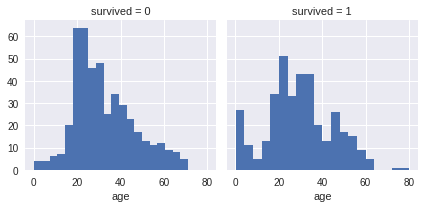

In [0]:
g = sns.FacetGrid(train_df, col='survived')
_ = g.map(plt.hist, 'age', bins=20)

**What if we split by sex AND survival?**

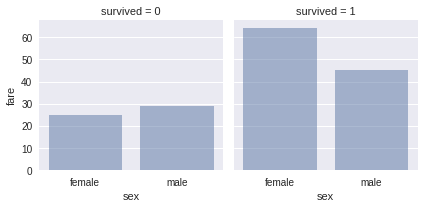

In [0]:
grid = sns.FacetGrid(train_df, col='survived')
_ = grid.map(sns.barplot, 'sex', 'fare', alpha=.5, ci=None)

We can observe how the group of individiuals that survived paid more that those who died. 

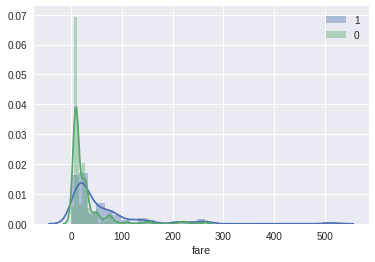

In [0]:
for i in train_df.survived.unique():
    sns.distplot(train_df['fare'][train_df.survived==i], kde=1,label='{}'.format(i))

_ = plt.legend()

Before feeding the training data to the classifier it is a good practice to study the correlation between features. If some features have very high correlation, we might be able to remove them. Furthermore, if some features are highly correlated with our target class, presumably those would have a higher impact on the final decision.

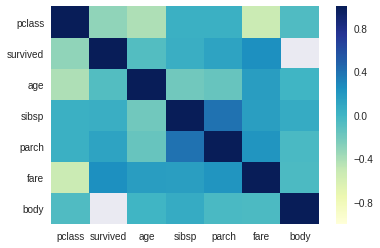

In [0]:
corr = train_df.corr()
sns.heatmap(corr, cmap="YlGnBu", annot=False)

# For values, put annot=True

We are about to split our features and target in different arrays. To decide which features will be used for training, we need to verify whether we have the complete information. If null values are present, we need to decide whether to fill values or remove the entire sample.

In [0]:
train_df.isna().sum()

pclass         0
survived       0
name           0
sex            0
age          100
sibsp          0
parch          0
ticket         0
fare           0
cabin        635
embarked       2
boat         524
body         826
home.dest    174
dtype: int64

## Dataset preprocessing

Many of the algorithms do not accept text features, let's convert the categories to discrete numerical values.

In [0]:
train_df.loc[:, 'sex'] = train_df.sex.map({'male':1, 'female':0}, )
train_df.loc[:, 'embarked'] = train_df.embarked.map( {'S': 0, 'C': 1, 'Q': 2})

test_df.loc[:, 'sex'] = test_df.sex.map({'male':1, 'female':0}, )
test_df.loc[:, 'embarked'] = test_df.embarked.map( {'S': 0, 'C': 1, 'Q': 2})

In [0]:
train_df = train_df.dropna(subset=['embarked', 'fare'])
test_df = test_df.dropna(subset=['embarked', 'fare'])

To facilitate our task, let's only keep those features without null values. 

In [0]:
x_train = train_df[['pclass', 'sex', 'sibsp','parch', 'fare', 'embarked']]
y_train = train_df['survived']

x_test = test_df[['pclass', 'sex', 'sibsp','parch', 'fare', 'embarked']]
y_test = test_df['survived']

Since the range of the features varies from one to another, some machine learning models have dificulties dealing with such ranges. Imagine a classifier that uses any sort of distance meassure to quantify the similarity of the datapoints, the features with bigger ranges will govern the decission. 

In [0]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train[['fare']])

x_train.loc[:, 'fare'] = scaler.transform(x_train[['fare']])
x_test.loc[:, 'fare'] = scaler.transform(x_test[['fare']])

## Supervised Learning

Now that we have prepared the dataset, let's look at different supervised models. The following function will help us to obtain the confusion matrix to evaluate the results.

A confusion matrix allows us to show the results of our classifier in a table form. The rows represent the predicted class whereas the columns show the true value. The following table shows a complete representation of the metrics around the confusion matrix.

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Preventive_Medicine_-_Statistics_Sensitivity_TPR%2C_Specificity_TNR%2C_PPV%2C_NPV%2C_FDR%2C_FOR%2C_ACCuracy%2C_Likelihood_Ratio%2C_Diagnostic_Odds_Ratio_2_Final_wiki.png/1600px-Preventive_Medicine_-_Statistics_Sensitivity_TPR%2C_Specificity_TNR%2C_PPV%2C_NPV%2C_FDR%2C_FOR%2C_ACCuracy%2C_Likelihood_Ratio%2C_Diagnostic_Odds_Ratio_2_Final_wiki.png =600x)

Source: https://www.wikimedia.org

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(None)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Linear Regression

Linear regression calculates the (continuous) value of the dependent variable given a set of independent variables. As the name suggests, it assumes that the relationship between the features and the output is linear and given by a set of coefficients:

$\hat{y}(x) = \sum_{i=1}^{d} w_i x_i + w_0$

where $w$ represents the parameters of the models, $w_0$ is a constant (bias) and $d$ is the number of features. The aim is to minimize the distance from the data points to the predictions of our linear model.

$\underset{w}{\arg\min} \frac{1}{2n} ||Xw - Y||^2$



![alt text](https://i.ibb.co/SB3GwGP/linear-regression.png)

In [0]:
lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

Since our target is a binary variable, this model might not be the appropriate. Look in the following cell at the values predicted by the model. We could binarize the output to [0, 1]. However, the objective was to present Linear Regression as it is one of the simplest and most common models.

In [0]:
y_pred[:10]

array([0.67038841, 0.10381236, 0.07913588, 0.07913588, 0.06394872,
       0.09445134, 0.63052477, 0.63052477, 0.06396748, 0.09464085])


### Logistic Regression 

Logistic regression aims to explain the relationship between the dependent variable and the independents variables, where the outcome of the dependen variable is binary. For each $x \in \mathbb{R}^d, w_0 \in \mathbb{R}$ and $w \in \mathbb{R}^d$, the probability of predicting class 1 is:

$P_{w_0, w}(Y=1 | X=x) = logistic(w_0 + wx)$

where:

$logistic(z)  =  \frac{1}{1+e^{-z}} = \frac{e^{z}}{1+e^{-z}}$

![alt text](https://i.ibb.co/rfWCjM7/logistic-regression.png)

In [0]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

Accuracy 75.00
Normalized confusion matrix


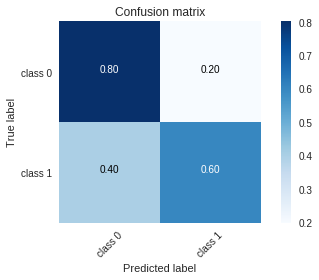

In [0]:
cm = metrics.confusion_matrix(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

print("Accuracy %.2f" % (accuracy*100))
plot_confusion_matrix(cm, classes= ['class 0', 'class 1'], normalize=True)

### SVM

A SVM is a discriminative classifier which finds a hyperplane that linearly separates the samples in two groups. The algorithm 


\begin{matrix}
\underset{w, t}{\min} &  \frac{1}{2}||w||_2^2  \\ 
s.t. &  y_i(wx_i - t) \ge 1 \text{ for all }i=1, 2, ..., n
\end{matrix}


<br>

Nothe that the SVM is only able to find a separator in two groups if they are linearly separable and always outputs the hyperplane with the maximum margin solution.. See the following picture:

![alt text](https://i.ibb.co/BPGgZBj/svm-blobs.png)

However, if the data is more complex a non linear classifier can be built using the **kernel trick**. In this case, the dot product is replaced by a non linear **kernel function**. The maximum margin hyperplane is now fit in this new feature space, usually a high dimensional space. 


![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Kernel_trick_idea.svg/1600px-Kernel_trick_idea.svg.png =600x)

Source: https://commons.wikimedia.org


In [0]:
svc = SVC()
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

Accuracy 73.98
Normalized confusion matrix


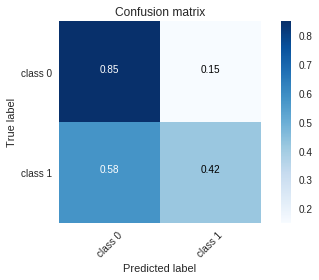

In [0]:
cm = metrics.confusion_matrix(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

print("Accuracy %.2f" % (accuracy*100))
plot_confusion_matrix(cm, classes= ['class 0', 'class 1'], normalize=True)

### Decission trees

A decision tree builds a decision model in a tree-like form during training time which is used during testing time to go from features observations(branches) to decissions (leaves). If the labels at the leaves are continous, the classifier is called regression trees. 

The procedure to build the tree consist on iterating through the different features and determine which one is able to obtain the best value for a given metric. Once a feature is selected, the dataset is splited in two and the procedure continues in each branch of the tree. Tipical metrics are the Gini coefficient or the Information Gain.

![alt text](https://i.ibb.co/sH34LMp/decision-tree-titanic.png =900x)



In [0]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)

y_pred = decision_tree.predict(x_test)

Accuracy 70.15
Normalized confusion matrix


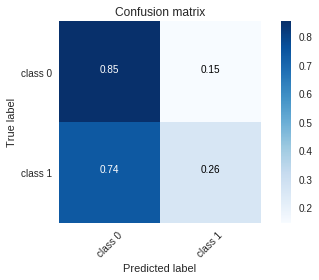

In [0]:
cm = metrics.confusion_matrix(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

print("Accuracy %.2f" % (accuracy*100))
plot_confusion_matrix(cm, classes= ['class 0', 'class 1'], normalize=True)

**How to visualize the generated tree**

In [0]:
dot_data = tree.export_graphviz(decision_tree, 
                                out_file=None, 
                                feature_names=x_train.columns,  
                                class_names=['survived', 'died'],  
                                filled=True, rounded=True,  ) 
graph = graphviz.Source(dot_data) 
graph.render("titanic") 

'titanic.pdf'

### Parameter search

Each of the models presented have a number of parameters we need to tweak in order to improve our performance. Let's now look at how we could automate this procedure using grid search. 

In [0]:
dict_classifiers = {
    "Logistic Regression": 
            {'classifier': LogisticRegression(),
                'params' : [{
                             'penalty': ['l1','l2'],
                             'C': [0.001,0.01,0.1,1,10,100,1000]
                            }]
            },
    "Linear SVM": 
            {'classifier': SVC(),
                 'params': [{
                             'C': [1, 10],
                             'gamma': [0.001, 0.0001],
                             'kernel': ['linear']
                            }]
            },
    "Decision Tree":
            {'classifier': DecisionTreeClassifier(),
                 'params': [{
                             'max_depth':[3, None]
                            }]
            }
}

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), 
                        plot=plt.plot):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, 
                                                            X, y, 
                                                            cv=cv, 
                                                            n_jobs=n_jobs, 
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plot(train_sizes, train_scores_mean, 'o-', color="r",
          label="Training Score")
    plot(train_sizes, test_scores_mean, 'o-', color="g",
          label="Cross-validation Score")

    plt.legend(loc=4)
    plt.show()

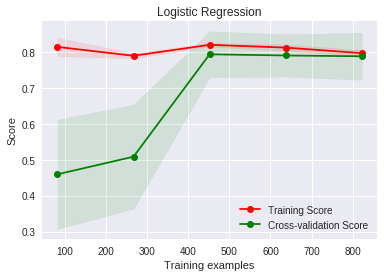

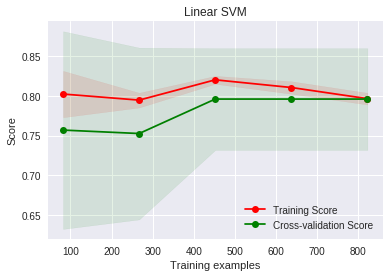

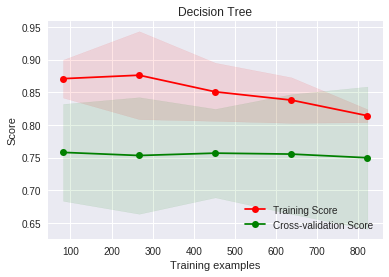

,Model,Train Score,Test Score
0,Logistic Regression,0.789934,0.739796
1,Linear SVM,0.796499,0.739796
2,Decision Tree,0.812910,0.765306


In [0]:
cv = 4
results = []

for key, classifier in dict_classifiers.items():
        
  grid = GridSearchCV(classifier['classifier'], 
                      classifier['params'],
                      refit=True,
                      cv= cv,
                      scoring = 'accuracy', # scoring metric
                      n_jobs = -1)
  estimator = grid.fit(x_train, y_train)

  train_score = estimator.score(x_train,y_train)
  test_score = estimator.score(x_test, y_test)
  
  plot_learning_curve(estimator, 
                      "{}".format(key),
                      x_train,
                      y_train.reshape(-1, 1),
                      ylim=None,
                      cv=10)

  results.append([key, train_score, test_score])
  
pd.DataFrame(data=results, columns=['Model', 'Train Score', 'Test Score'])

### Feature Importance

The **importance** tells us how big is the influence of the feature when making a decision. It is a good practice to look at what features have more weight since we might want to engineer more features around those or discard those with relatively low importance. 

Decision Trees in Sklearn comes with a handy attribute that returns the importance of the features. It uses the Gini importance to determine the relative weight of each features.

In [0]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

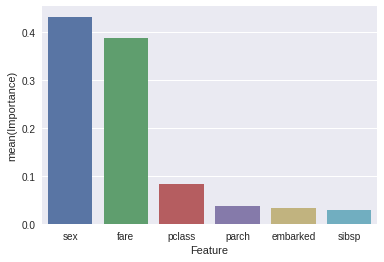

In [0]:
ft_importance = pd.DataFrame(data={'Feature':x_train.columns, 'Importance':decision_tree.feature_importances_})
ft_importance = ft_importance.sort_values(by='Importance', ascending = False)
sns.barplot(x="Feature", y="Importance", data=ft_importance)

## Unsupervised Learning

In this section we are going to look at a unsupervised problem and the k-means algorihtm. We will use the Iris dataset to try to find inner relationships in the data. 

In [0]:
iris = datasets.load_iris()
X = pd.DataFrame(data=iris.data, columns=iris.feature_names)
y = pd.DataFrame(data=iris.target, columns=['species'])

### Visualization

Text(0.5, 1.0, 'sepal length (cm) vs sepal width (cm)')

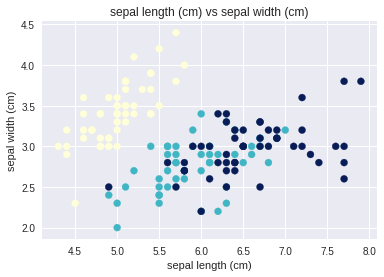

In [0]:
ft_1 = 'sepal length (cm)'
ft_2 = 'sepal width (cm)'

plt.scatter(X[ft_1], X[ft_2], c=y.species.values, cmap="YlGnBu")
plt.xlabel(ft_1)
plt.ylabel(ft_2)
plt.title(ft_1 + ' vs ' + ft_2)

### K-Means

Separates the samples *X* in *k* clusters based on the distance of the sample to the center of the cluster. 

There are a few concepts that needs clarification in the previous statement: 
-  where is the center of the cluster? 
-  how do we compute the distance to the center?

Imagine we have a set of samples $X=(x_1, x_2, ..., x_n)$ where each sample is a d-dimensional vector, k-means will group the points in $k$ clusters by minimizing the intra-cluster sum of squares: 

$\underset{S}{\arg\min} \sum_{i=1}^k  \sum_{x \in S} (||x-\mu_i||^2)$

This is equivalent to minimizing the following:

$\underset{S} \sum_{i=1}^k  \frac{1}{2S_i} \sum ||x-y||^2)$

K-means works as follows:


1.   $k$ centroids are randomly sampled
2.   The elements in the dataset are assigned to the closest cluster
3.   Centroids are recomputed and assined to  the mean point of every cluster
4.   Repeat until some stopping criteria (same centroids, dissimilarity in cluster assignment)


![alt text](https://upload.wikimedia.org/wikipedia/commons/d/d5/Kmeans_animation.gif =300x)

Source: https://commons.wikimedia.org

In [0]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X, i)
labels = kmeans.labels_

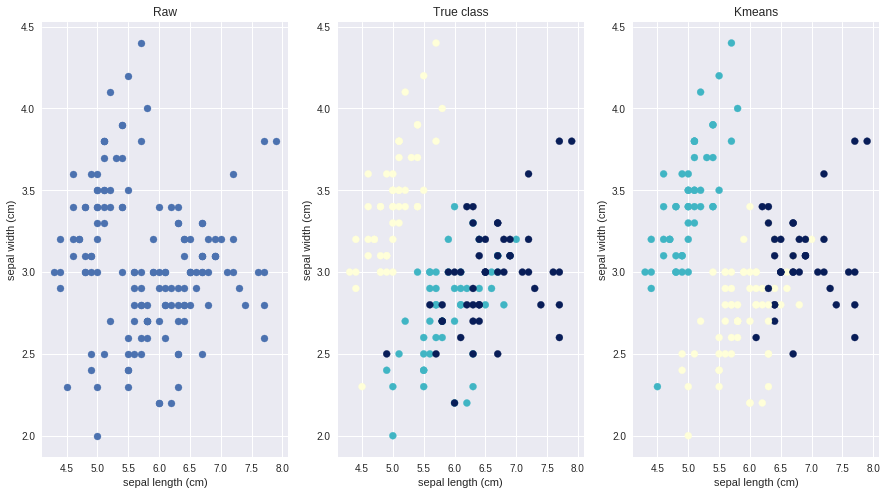

In [0]:
ft_1 = 'sepal length (cm)'
ft_2 = 'sepal width (cm)'

f, ax = plt.subplots(3,3,figsize=(15,8))

plt.subplot(1, 3, 1)
plt.scatter(X[ft_1], X[ft_2])
plt.xlabel(ft_1)
plt.ylabel(ft_2)
_ = plt.title('Raw')

plt.subplot(1, 3, 2)
plt.scatter(X[ft_1], X[ft_2], c=y.species.values, cmap="YlGnBu")
plt.xlabel(ft_1)
plt.ylabel(ft_2)
_ = plt.title('True class')

plt.subplot(1, 3, 3)
plt.scatter(X[ft_1], X[ft_2], c=labels.astype(np.float), cmap="YlGnBu")
plt.xlabel(ft_1)
plt.ylabel(ft_2)
_ = plt.title('Kmeans')

## Neural Networks

In [0]:
tr_samples, n_features = x_train.shape
te_samples, _ = x_test.shape

In [0]:
model = Sequential()
model.add(Dense(128, input_shape=(n_features,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

opt = rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.fit(x_train, y_train, epochs=10, batch_size=64)

y_prob = model.predict(x_test)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
914/914 [==============================] - 1s 719us/step - loss: 0.6520 - acc: 0.5744
Epoch 2/10
914/914 [==============================] - 0s 27us/step - loss: 0.6385 - acc: 0.6028
Epoch 3/10
914/914 [==============================] - 0s 28us/step - loss: 0.6284 - acc: 0.6357
Epoch 4/10
914/914 [==============================] - 0s 27us/step - loss: 0.6203 - acc: 0.6685
Epoch 5/10
914/914 [==============================] - 0s 27us/step - loss: 0.6130 - acc: 0.6827
Epoch 6/10
914/914 [==============================] - 0s 27us/step - loss: 0.6065 - acc: 0.6893
Epoch 7/10
914/914 [==============================] - 0s 27us/step - loss: 0.6001 - acc: 0.6980
Epoch 8/10
914/914 [==============================] - 0s 27us/step - loss: 0.5939 - acc: 0.7068
Epoch 9/10
914/914 [==============================] - 0s 27us/step - loss: 0.5883 - acc: 0.7057
Epoch 10/10
914/914 [==============================] - 0s 26us/step - loss: 0.5834 - ac

In [0]:
y_pred = np.where(y_prob > 0.5, 1, 0)

display(metrics.confusion_matrix(y_test, y_pred))
display(metrics.accuracy_score(y_test, y_pred))

array([[272,  20],
       [ 89,  11]])

0.7219387755102041

## Kaggle Competition

To practice the tecniques we have learned today, we will do a competition on https://www.kaggle.com/. 

Please register and join the following challenge. The aim is to obtain the highest accuracy using any of the models we have learned or new ones that you would like to try. 


We have added a sample submission and the corresponding code as a reference. 

# References

*  https://www.kaggle.com/amitkumarjaiswal/beginner-s-tutorial-to-titanic-using-scikit-learn

*  https://en.wikipedia.org/wiki/Reinforcement_learning